### Table des matières
* [Partie1: Structure des données](#p1)
  * [1.Les librairies](#lib)
  * [2.Dataset initial](#di)
  * [3.Idée d'application](#app)
       
      
* [Parti2:Nettoyage des données](#p2)
  * [1.Les lignes et les colonnes](#col)
  * [2.Les outliers](#ou)
  

# Partie1: Structure des données <a class="anchor" id="p1"></a>
## 1.Les librairies<a class="anchor" id="lib"></a>

In [ ]:
#!pip3 install plotly

In [208]:
import pandas as pd #(Vaex – Faster Pandas Alternate in Python)
import numpy as np
from hurry.filesize import size
import missingno as msno
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('seaborn')
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [209]:
import warnings
warnings.filterwarnings('ignore')


## 2.Dataset initial<a class="anchor" id="di"></a>

In [210]:
df=pd.read_csv("data.csv",sep='\t',on_bad_lines='skip',low_memory=False)

In [211]:
def print_shape(dataframe):
    print('Number of rows:', dataframe.shape[0],'\n')
    print('Number of columns:', dataframe.shape[1])

In [6]:
#shape
print('Initial dataset \n')
print_shape(df)

Initial dataset 

Number of rows: 320772 

Number of columns: 162


In [212]:
def print_memory(dataframe):
    #Memory consumption
    df_memory = dataframe.memory_usage().sum()
    # Let's print out the memory consumption
    print('Total Current memory is-', df_memory,'Bytes.','===>',size(df_memory))


In [8]:
print_memory(df)


Total Current memory is- 415720640 Bytes. ===> 396M


In [113]:
#columns
cols= df.columns.tolist()
print('columns list',cols)

columns list ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnn

In [213]:
def print_nb_duplicated_rows(dataframe,cols):
    #duplicated rows
    dataframe=dataframe[cols]
    bool_series = dataframe.duplicated()
    print('Number of duplicated rows:',(bool_series).sum())


In [13]:
print_nb_duplicated_rows(df,cols)

Number of duplicated rows: 0


In [214]:
def print_missing_val(df,how):
    if how=='graph':
        #plot % of missing
        msno.bar(df)
    elif how=='values':
        #print % of missing
        df.isnull().mean()

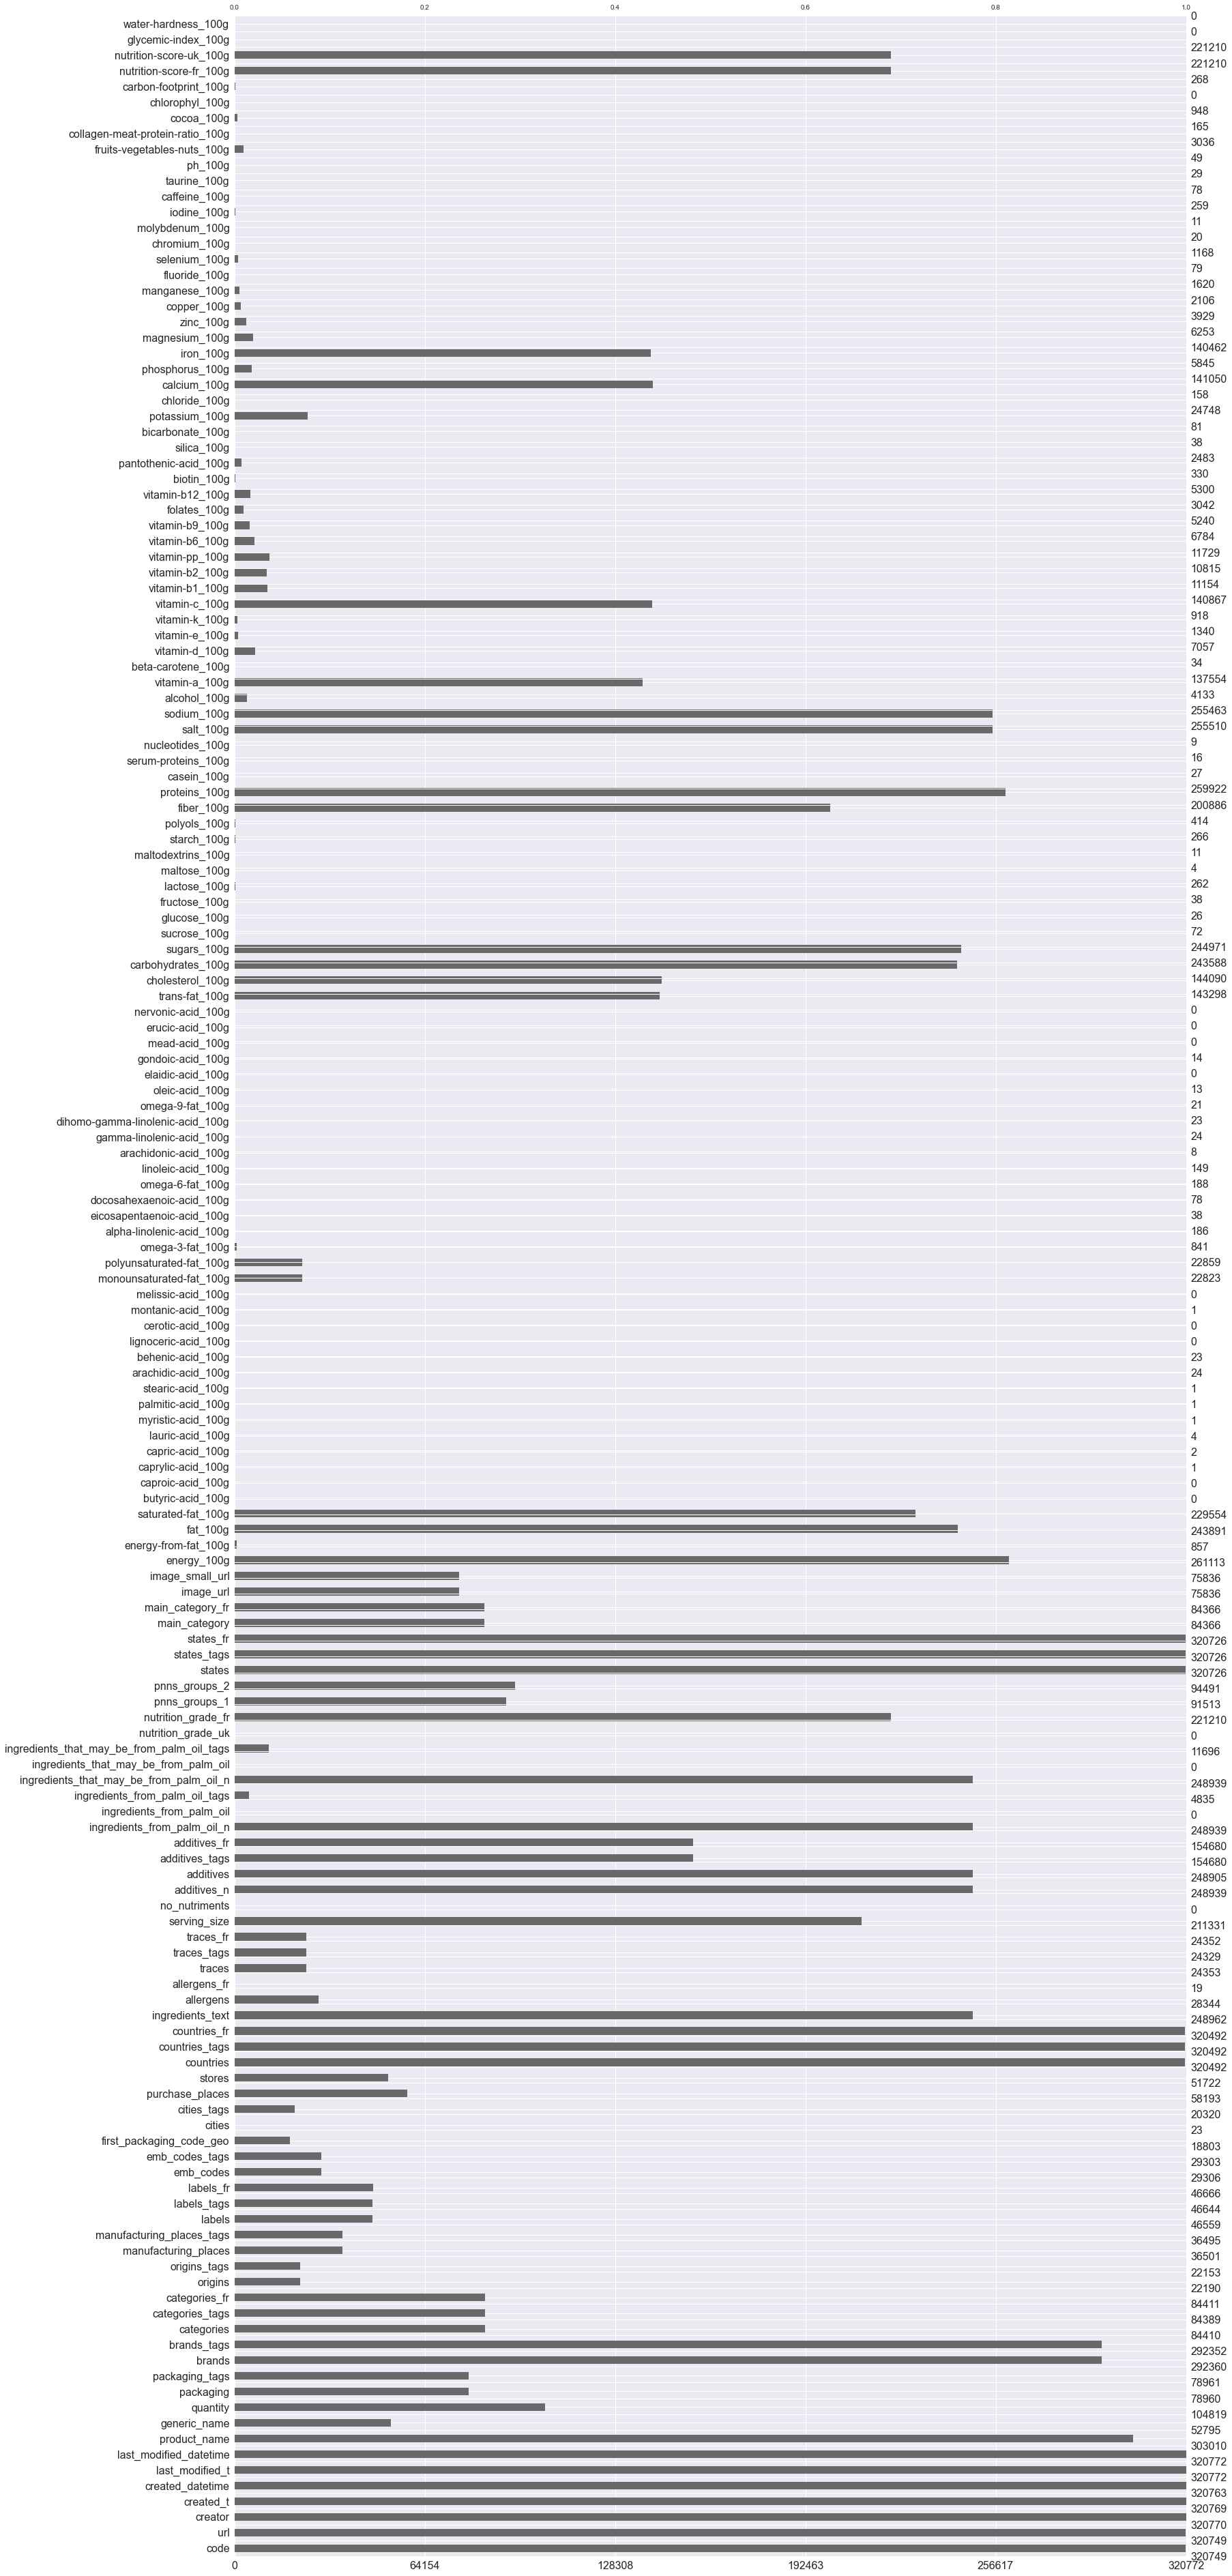

In [16]:
print_missing_val(df,'graph')

## 3.Idée d'application<a class="anchor" id="app"></a>
<p> L'idée est pour un produit scanné via son code à barre, l'application permet d'afficher si le produit est excellent, bon ou mauvais en fonction d'un score calculé.
 <br>
Lorsque son impact est jugé négatif , elle permet de recommander des produits.
 <br>
Le score est un pourcentage:
 <br>
- excellent: 75<=score<=100
 <br>
- bon: 50<=score<=74
 <br>
- médiocre: 25<=score<=49
 <br>
- mauvais: score<=25
 
 Le score est  calculé en fonction de la qualité nutritionnelle,la teneur de fruits , légumes et noix et la présence d'additifs.
    <br>
 Les variables à utiliser:'code','pnns_groups_1', 'pnns_groups_2','energy_100g','fat_100g', 'saturated-fat_100g','sugars_100g','fiber_100g', 'proteins_100g','sodium_100g','fruits-vegetables-nuts_100g','additives_n'
  
   </p>                 

# Partie2: Nettoyage des données <a class="anchor" id="p2"></a>
## 1.Les lignes et les colonnes<a class="anchor" id="col"></a>

In [314]:
vs=['code','pnns_groups_1', 'pnns_groups_2','energy_100g','fat_100g', 'saturated-fat_100g','sugars_100g','fiber_100g', 'proteins_100g','sodium_100g','fruits-vegetables-nuts_100g','additives_n']
df_app=df[vs]


In [262]:
print_memory(df_app)

Total Current memory is- 30794240 Bytes. ===> 29M


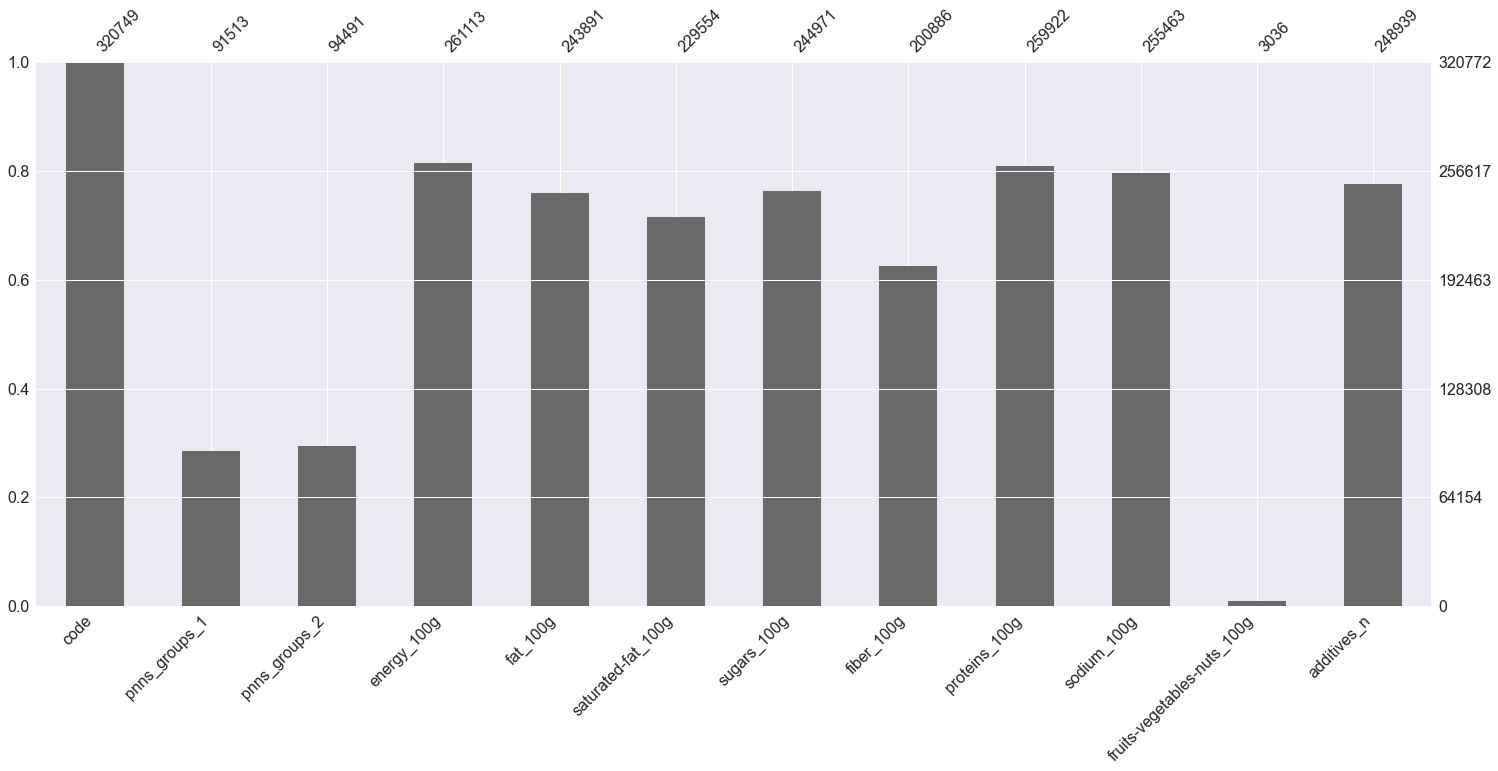

In [263]:
print_missing_val(df_app,'graph')

In [315]:
print_nb_duplicated_rows(df_app,'code')
#delete duplicated product
df_app = df_app.drop_duplicates('code', keep='first')


Number of duplicated rows: 22


In [316]:
def fill_nan1(df,col,init,cp):    
    nb_nan_code=df[col].isna().sum()
    for cp in range(nb_nan_code):
        df[col]=df[col].fillna(init+str(cp)) 

In [317]:
fill_nan1(df_app,'code','200',1)                               


In [318]:
ingr1=['fat_100g', 'saturated-fat_100g','sugars_100g','fiber_100g', 'proteins_100g','sodium_100g']

In [267]:
#check values 
#min max of each ingredient column in the datframe
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])


In [319]:
l1=ingr1+['energy_100g']
df_app[l1].apply(minMax)

,fat_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g
min,0.00,0.0,-17.86,-6.7,-800.0,0.0,0.0
max,714.29,550.0,3520.00,5380.0,430.0,25320.0,3251373.0


In [320]:
 #keep only rows with ingr1 values  between 0 and 100

#'fruits-vegetables-nuts_100g'==> is a %
#'additives_n'==> is a number of food additives
for ing in ingr1:
    df_app.drop(df_app[(df_app[ing] < 0) | (df_app[ing] > 100)].index,inplace=True)

In [321]:
#check energy values 1g(glucid)==>4kcal, 1g(protein)==>4kcal, 1g(lipid)==>9kcal,if a product of 100g contains onlylipid, so it has 900kcal like energy
#replace outliers with 900*4,186(1 kcal = 4,1868 kJ) because energy_100g is on kJ
seuil_energy=900*4.186
df_app[df_app['energy_100g']>seuil_energy].shape    
df_app['energy_100g'].mask(df_app['energy_100g'] >seuil_energy, seuil_energy, inplace=True)




In [322]:
#keep only rows with 'fat_100g'>='saturated-fat_100g'
df_app.drop(df_app[df_app['saturated-fat_100g']>df_app['fat_100g']].index,inplace=True)

In [323]:
df_app[l1].apply(minMax)

,fat_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,100.0,100.0,100.0,100.0,100.0,100.0,3767.4


In [273]:
print_shape(df_app)

Number of rows: 320355 

Number of columns: 12


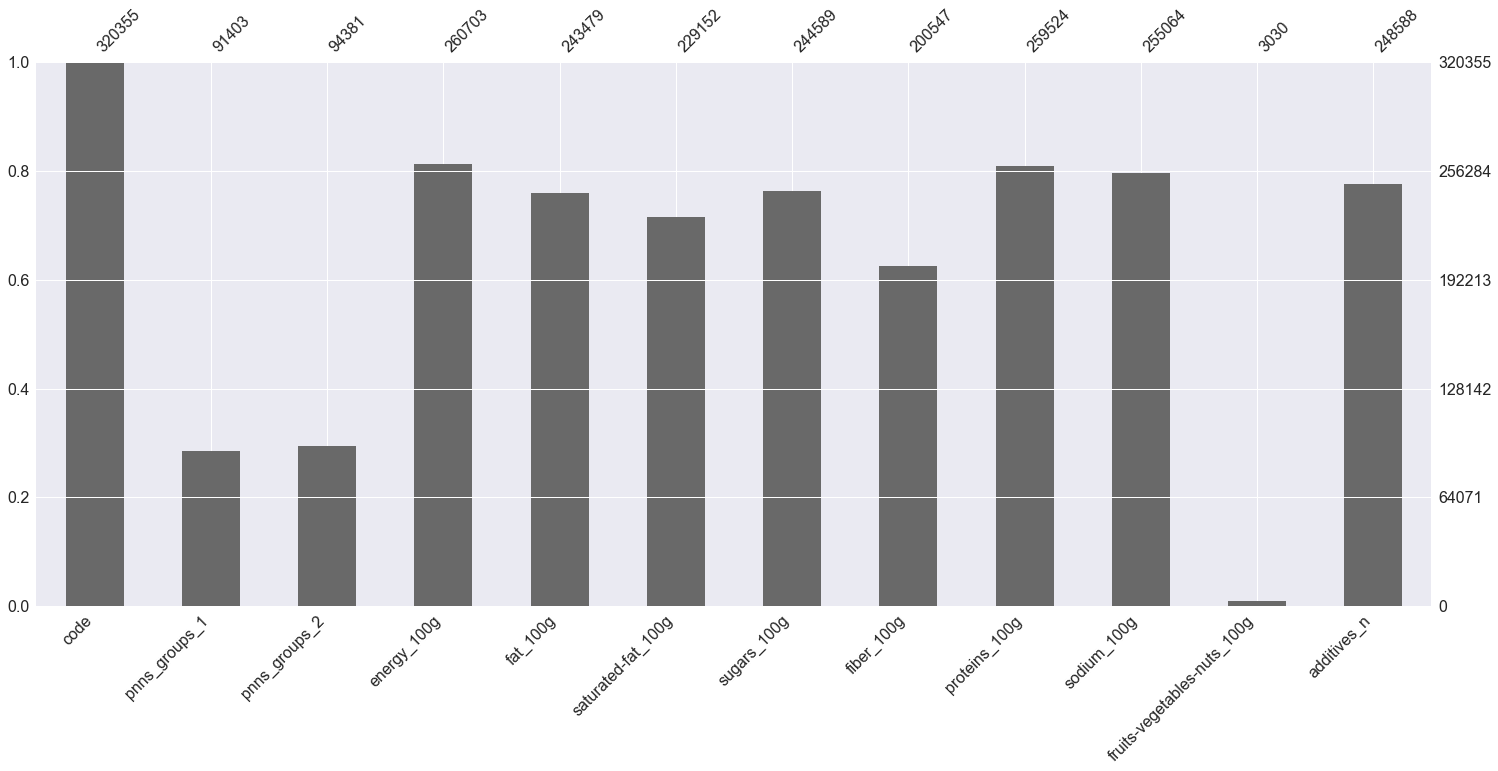

In [274]:
print_missing_val(df_app,'graph')

**Remarque**
<br>
 - fruits_vegetables_nuts_100g  contains a lot of nan it will not be considered in the variables application

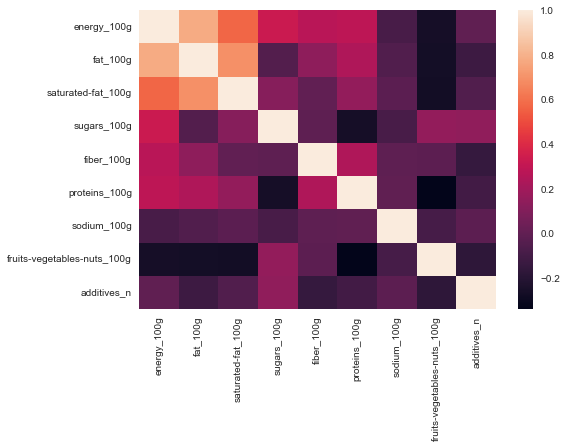

In [275]:
sns.heatmap(df_app.corr());

In [324]:

def impute_nan(dataframe,cols,method,stategy):
    df=dataframe[cols]
    cols = [col for col in df.columns if df[col].dtype != object]
    if method=='Iterative_Imputer':
        # Iterative Imputation
        iter_imputer = IterativeImputer(random_state=42)
        df_imputed = iter_imputer.fit_transform(df[cols])        
        #df_imputed = pd.DataFrame(iter_imputed, columns=cols)
    elif method=='KNN_Imputer':
        # create an object for KNNImputer
        knn_imputer = KNNImputer(n_neighbors=2)
        df_imputed=knn_imputer.fit_transform(knn_imputer)
    df_output=df_imputed
    return df_output

In [325]:
#before imputation,we make a copy of df_app called df_app_copy 
df_app_copy=df_app.copy()


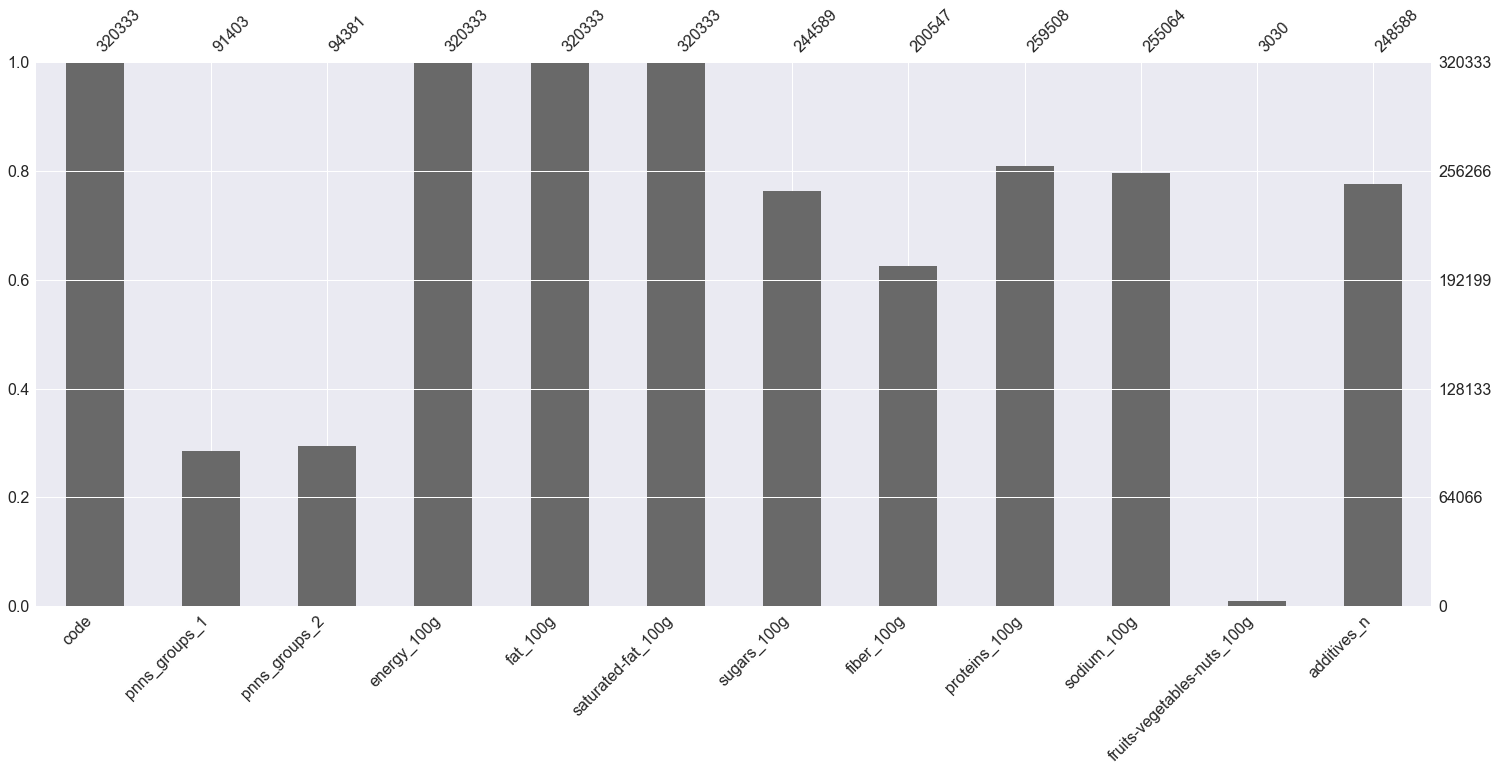

In [326]:
correlated_features=[['fat_100g','energy_100g'],['saturated-fat_100g','energy_100g'],['fat_100g', 'saturated-fat_100g']]

for col in correlated_features:
    df_after_imputation=impute_nan(df_app,col,'Iterative_Imputer','')
    df_app[col]=df_after_imputation
print_missing_val(df_app,'graph')


In [327]:
#control min max
print(df_app[l1].apply(minMax))

       fat_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
min   -6.538883           -1.636303          0.0         0.0            0.0   
max  100.000000          100.000000        100.0       100.0          100.0   

     sodium_100g  energy_100g  
min          0.0     0.000000  
max        100.0  4313.319568  


**Remarque**
<br>
 - Imputation gives <0 values fat_100g

In [328]:
def remove_negatif(dataframe,column,limit):
    #df_no_negatif = dataframe[(dataframe[column]>limit)]
    dataframe.drop(dataframe[(dataframe[column] < limit)].index,inplace=True)

In [329]:
#keep only values with postif fat_100g and saturated-fat_100g
remove_negatif(df_app,'fat_100g',0)
remove_negatif(df_app,'saturated-fat_100g',0)

In [330]:
print_shape(df_app)

Number of rows: 300253 

Number of columns: 12


In [331]:
#control min max
print(df_app[l1].apply(minMax))

     fat_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
min       0.0                 0.0          0.0         0.0            0.0   
max     100.0               100.0        100.0       100.0          100.0   

     sodium_100g  energy_100g  
min          0.0     0.000000  
max         92.5  4313.319568  


## 2.Les outliers<a class="anchor" id="ou"></a>

In [332]:
list_pnns1=df_app['pnns_groups_1'].unique().tolist()
print(list_pnns1)

[nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks', 'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs', 'Beverages', 'Fat and sauces', 'fruits-and-vegetables', 'Milk and dairy products', 'Salty snacks', 'sugary-snacks', 'cereals-and-potatoes', 'salty-snacks']


**Remarques concernant les valeurs de pnns_groups_1 (à regarder plus tard)**
<br>
  - 'Sugary snacks':'sugary-snacks'
<br>
  - 'Salty snacks' : 'salty-snacks'
<br>
  - 'Fruits and vegetables' : 'fruits-and-vegetables'
<br>
  - 'Cereals and potatoes' : 'cereals-and-potatoes'

In [333]:
list_pnns2=df_app['pnns_groups_2'].unique().tolist()
print(list_pnns1)

[nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks', 'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs', 'Beverages', 'Fat and sauces', 'fruits-and-vegetables', 'Milk and dairy products', 'Salty snacks', 'sugary-snacks', 'cereals-and-potatoes', 'salty-snacks']


In [79]:
#df_app[df_app['pnns_groups_2']=='unknown'].shape[0]*100/df_app.shape[0]==7% of data
#df_app[df_app['pnns_groups_2'].isna()].shape[0]*100/df_app.shape[0]==70% of data
df_app['pnns_groups_2'].isna().mean()

0.7053659785285937

**Remarques concernant les valeurs de pnns_groups_2**
<br>
  - 'Legumes':'legumes'======>boxplot shows that are 2 different pnss_groups
<br>
  - 'Vegetables' : 'vegetables'======>boxplot shows that are 2 different pnss_groups
<br>
  - 'Fruits ' : 'fruits'======>boxplot shows that are 2 different pnss_groups
<br>
  - 'Nuts' : 'nuts'======>boxplot shows that lignes with pnns_groups_2 can be deleted
<br>
  - 'unknown' : **what will we do** 
 

In [334]:
def plot_box(pn,data,ingr,nb):    
    if pd.isna(pn)==False:
        myFig=plt.figure(figsize=(10,4))
        data_pnns=data[data['pnns_groups_2']==pn]
        data=data_pnns[ingr]
        ax=data.boxplot(column=ingr,figsize=(15,5))
        ax.set_title(pn)
        figname='Boxplots/boxplot'+str(nb)+pn+'.png'
        myFig.savefig(figname, format="png")



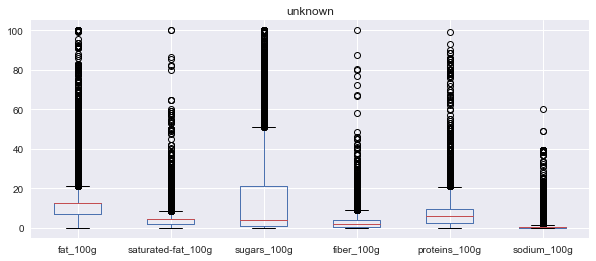

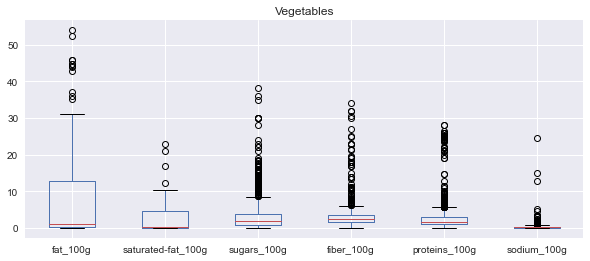

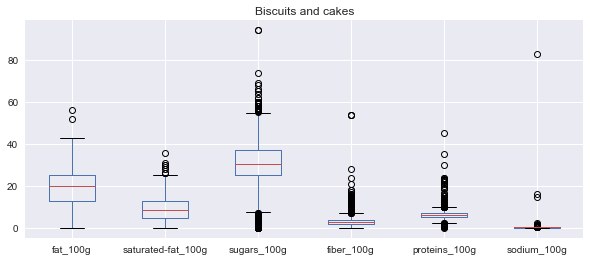

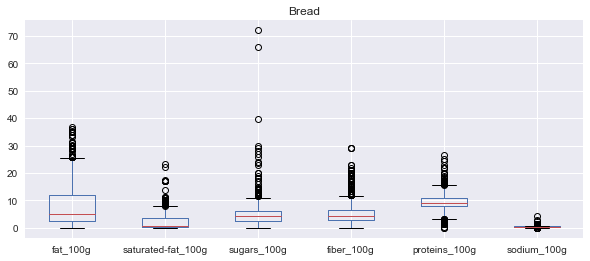

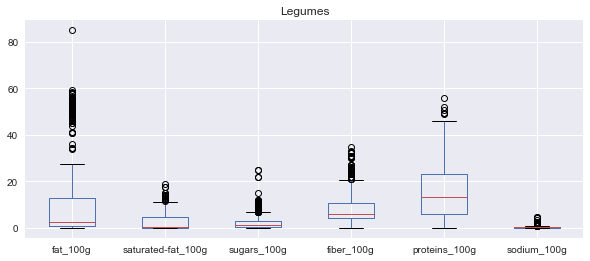

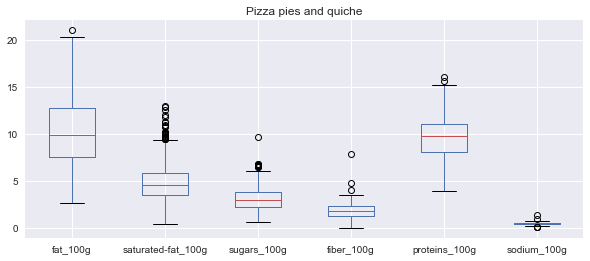

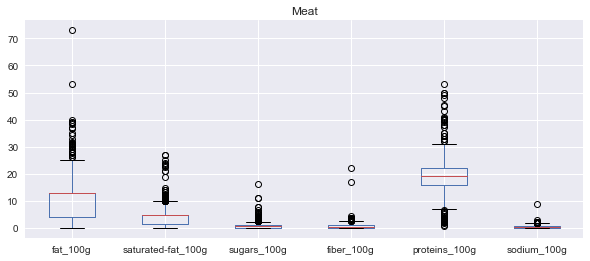

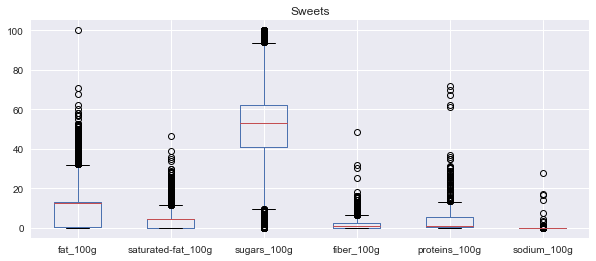

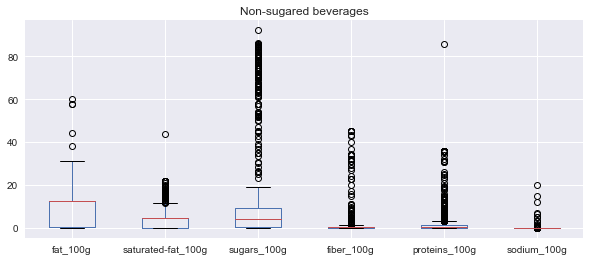

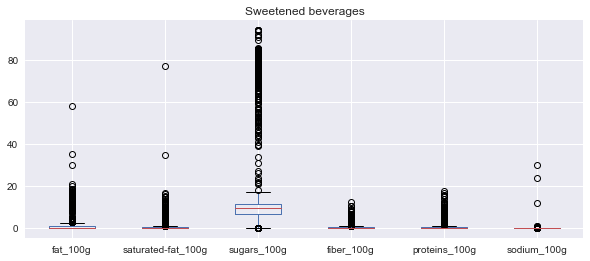

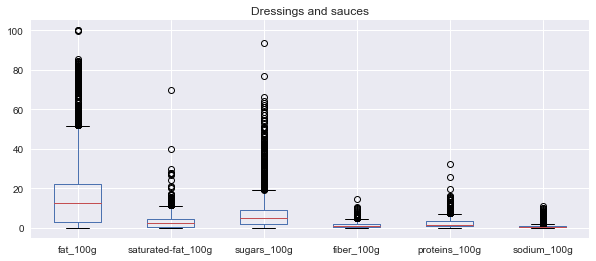

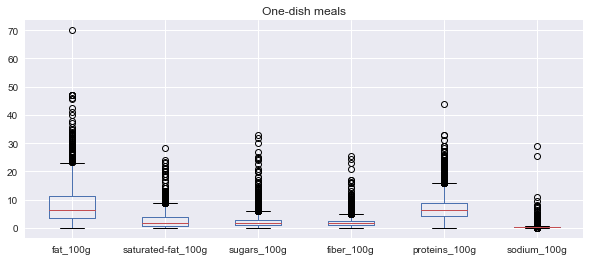

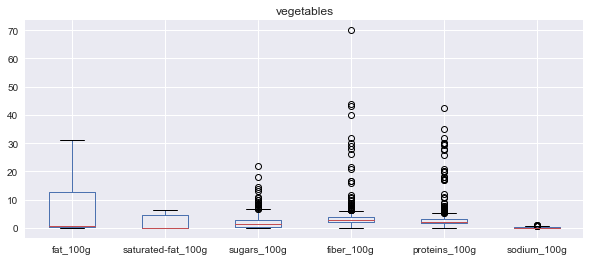

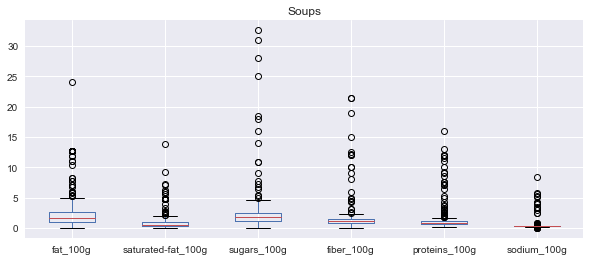

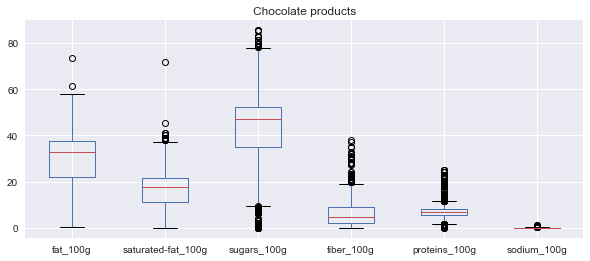

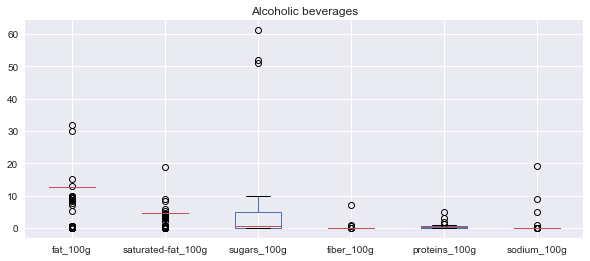

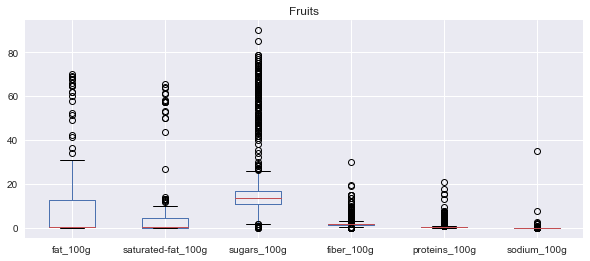

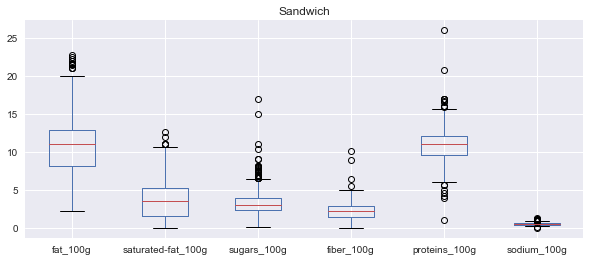

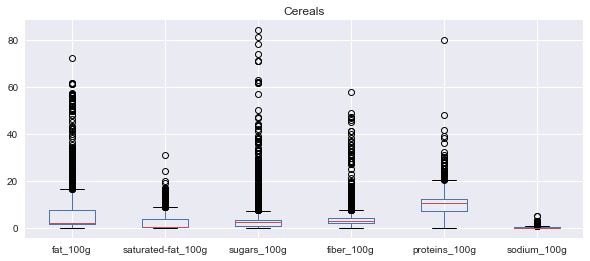

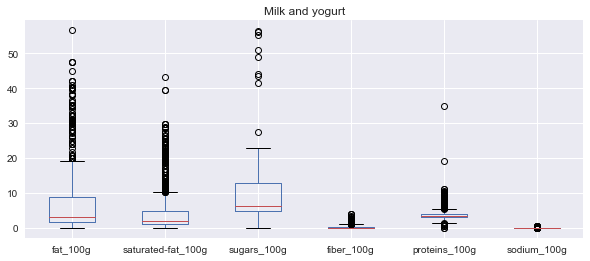

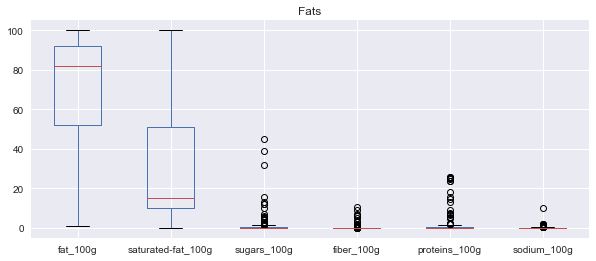

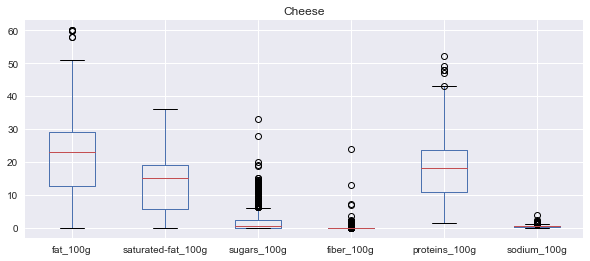

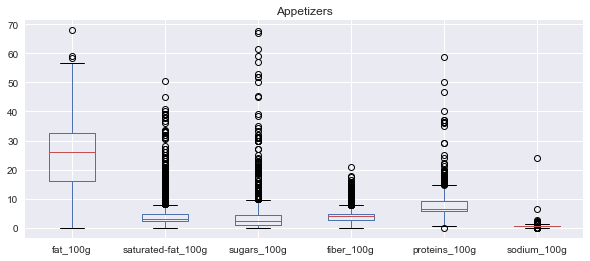

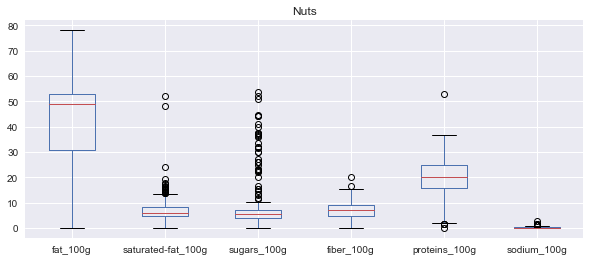

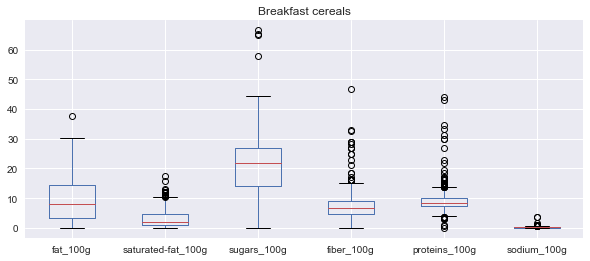

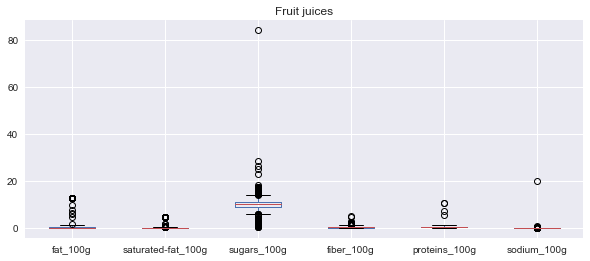

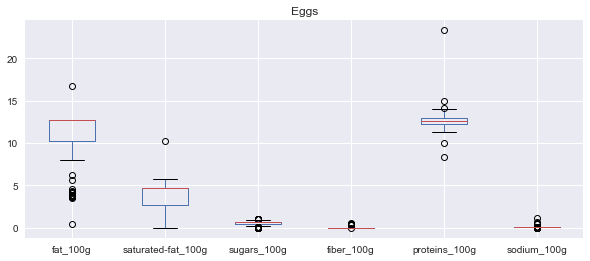

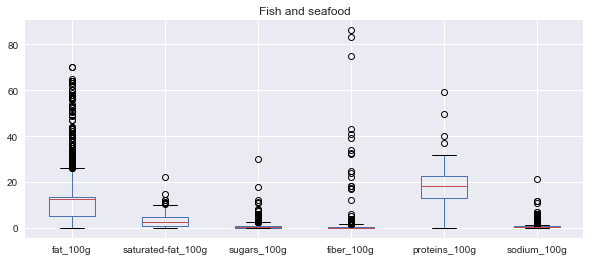

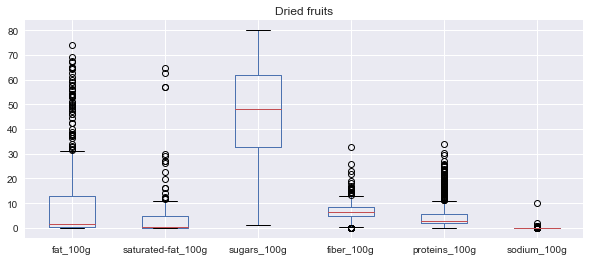

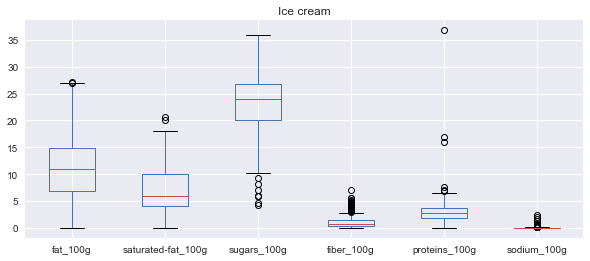

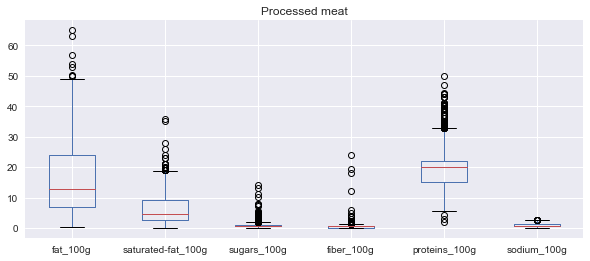

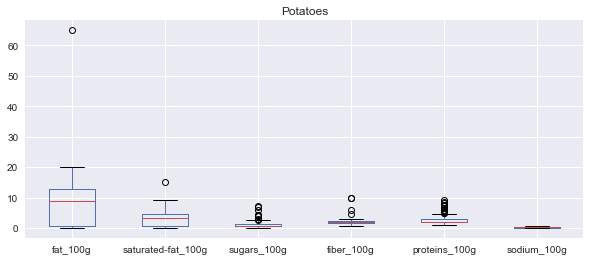

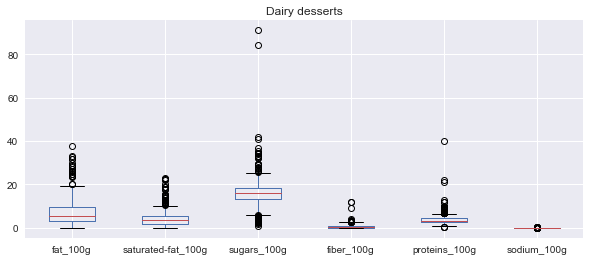

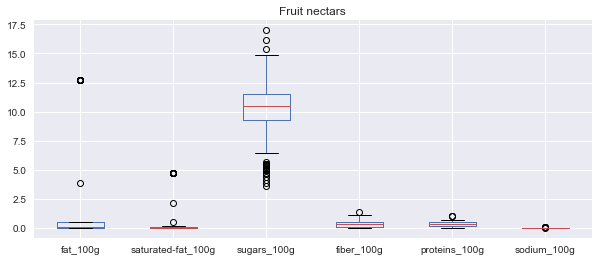

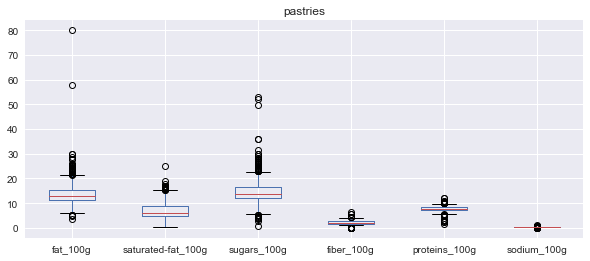

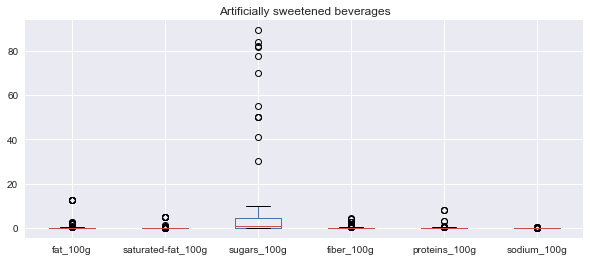

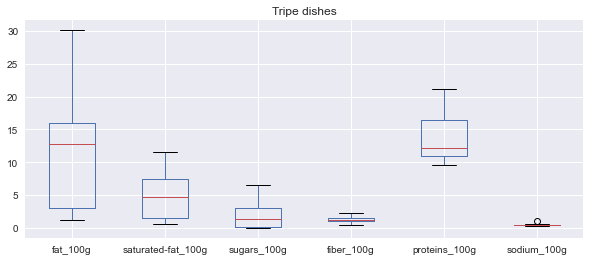

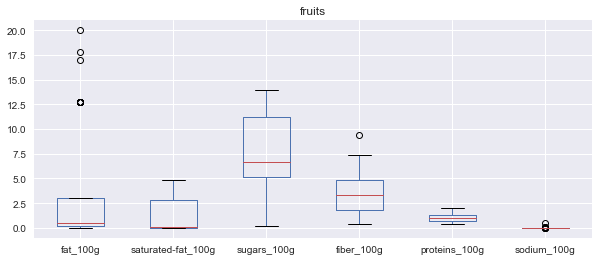

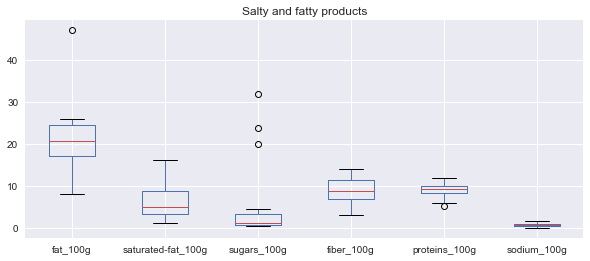

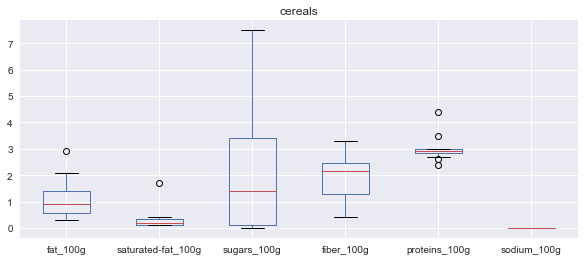

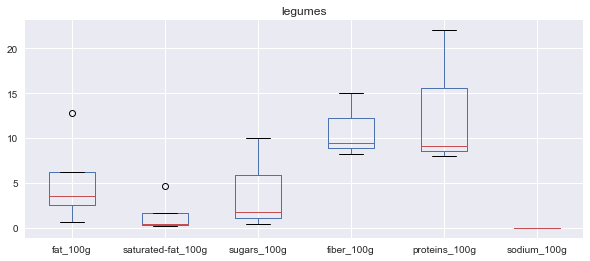

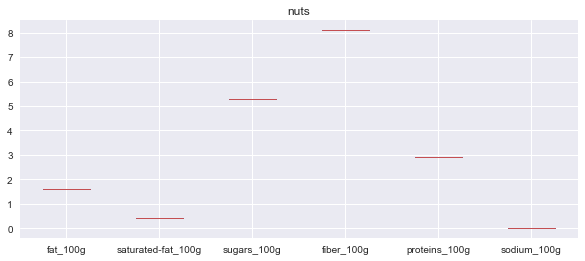

In [292]:
i=0
for pn in list_pnns2:
    i+=1
    plot_box(pn,df_app,ingr1,i)

In [294]:
def detect_outlier(dataframe,column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    
    if pd.isna(lower_limit):
        print('lower limit of ',column,' is nan')
    if pd.isna(upper_limit):
        print('upper_limit of ',column,' is nan')
    #here are the outliers
    dataframe[(dataframe[column]<lower_limit)|(dataframe[column]>upper_limit)]
    return lower_limit,upper_limit

In [353]:
def remove_outlier(dataframe,column,lower_limit,upper_limit):
    #df_no_outlier = dataframe[(dataframe[column]>lower_limit)&(dataframe[column]<upper_limit)]
    dataframe.drop(dataframe[(dataframe[column]<lower_limit)|(dataframe[column]>upper_limit)].index,inplace=True)
    #return df_no_outlier

In [297]:
 #Q1 = df_app_copy[ingr1[0]].quantile(0.25)
features=df_app.columns
print(features)

Index(['code', 'pnns_groups_1', 'pnns_groups_2', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g', 'additives_n'],
      dtype='object')


In [354]:
df_app_pnss=df_app.copy()

In [343]:
df_app_pnss.columns

Index(['code', 'pnns_groups_1', 'pnns_groups_2', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g', 'additives_n'],
      dtype='object')

Pizza pies and quiche
before deleting outliers:

Number of rows: 515 

Number of columns: 12
after deleting outliers:

Number of rows: 442 

Number of columns: 12


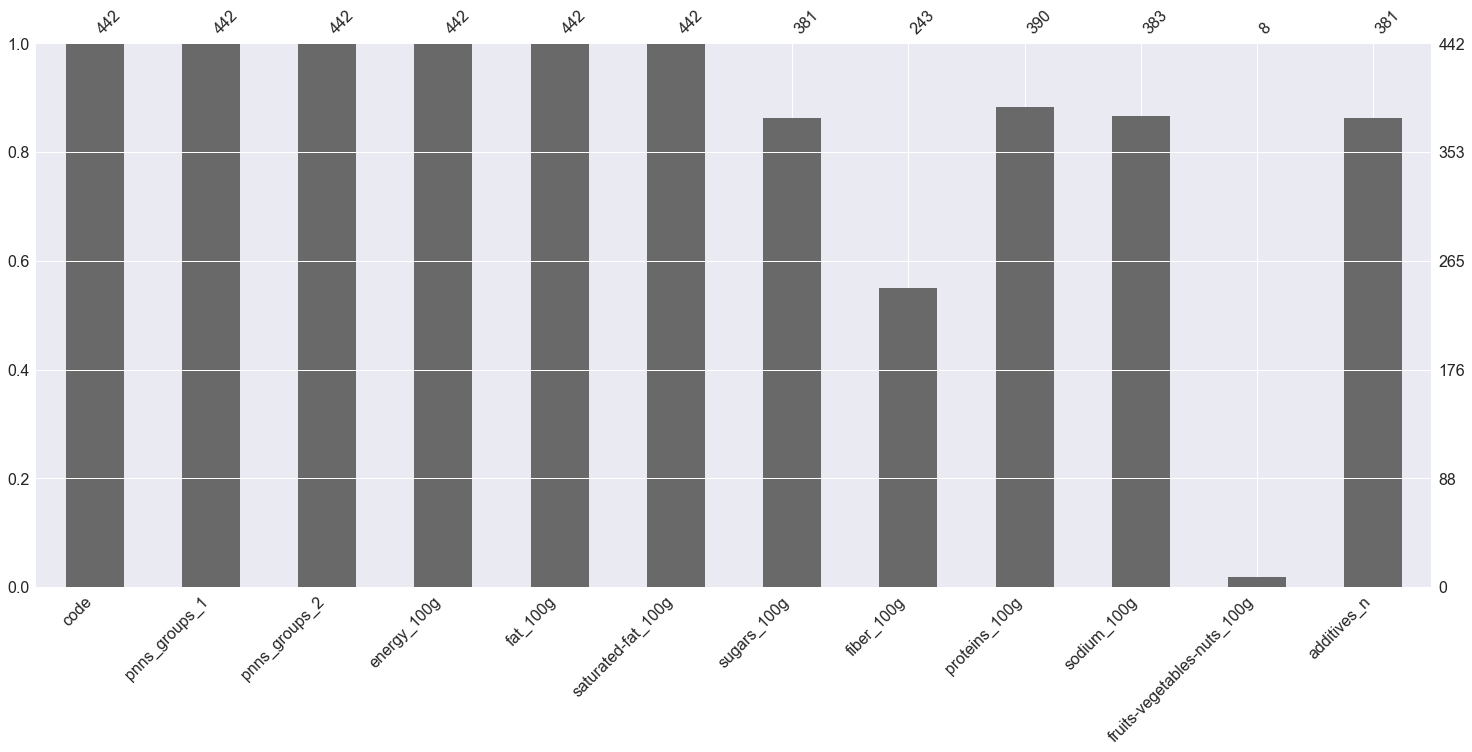

In [355]:
#for pn in list_pnns2[2]:
#test for 1 element of list_pnns2 

pn=list_pnns2[6]
print(pn)
    #if pd.isna(pn)==False:
df_app_pnss=df_app_pnss[df_app_pnss['pnns_groups_2']==pn]
print('before deleting outliers:\n')
print_shape(df_app_pnss)
ings=['energy_100g', 'fat_100g',
       'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'sodium_100g']

for ing in ings:
    lower_limit,upper_limit=detect_outlier(df_app_pnss,ing)
    #print(upper_limit)
    remove_outlier(df_app_pnss,ing,lower_limit,upper_limit)
        
print('after deleting outliers:\n')
print_shape(df_app_pnss)       
print_missing_val(df_app_pnss,'graph')  

before deleting outliers:

Number of rows: 300253 

Number of columns: 12
lower limit of  fiber_100g  is nan
upper_limit of  fiber_100g  is nan
lower limit of  proteins_100g  is nan
upper_limit of  proteins_100g  is nan
after deleting outliers:

Number of rows: 300253 

Number of columns: 12


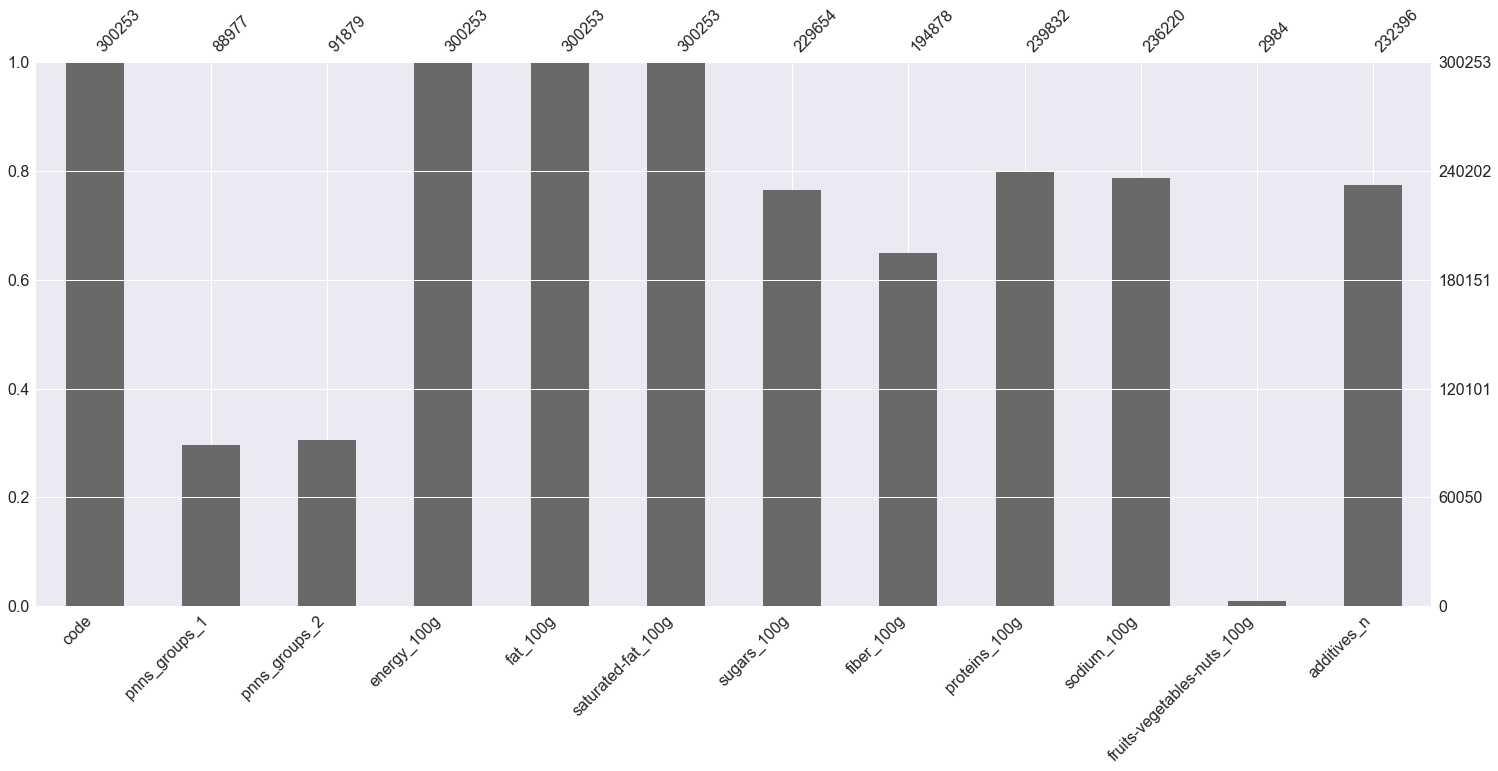

In [363]:
ings=['energy_100g', 'fat_100g','saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g','sodium_100g']
print('before deleting outliers:\n')
df_no_outlier=df_app.copy()
print_shape(df_no_outlier)
#for pn in list_pnns2:
#    if (pd.isna(pn)==False) & (pn!='unknown'):
#        df_app_pnss=df_app[df_app['pnns_groups_2']==pn]
#        for ing in ings:
            #print(pn)
#            lower_limit,upper_limit=detect_outlier(df_app_pnss,ing)    
 #           remove_outlier(df_app_pnss,ing,lower_limit,upper_limit)
            
#df_no_outlier[df_no_outlier['pnns_groups_2']==pn]=df_app_pnss
        
#print('after deleting outliers:\n')
#print_shape(df_no_outlier)       
#print_missing_val(df_no_outlier,'graph') 

In [301]:
#control min max
print(df_app[l1].apply(minMax))

     fat_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
min       0.0                 0.0          0.0         0.0            0.0   
max     100.0               100.0        100.0       100.0          100.0   

     sodium_100g  energy_100g  
min          0.0     0.000000  
max         92.5  4313.319568  
